In [1]:
import pandas as pd
tweets = pd.read_csv("Tweetss.csv")

tweets.isnull().values.any()

tweets.shape


(14640, 2)

In [2]:
tweets.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


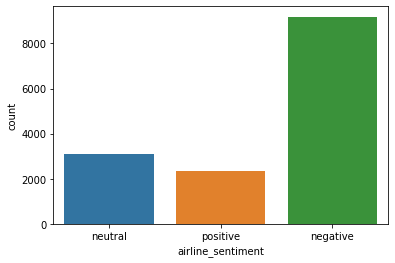

In [3]:
import seaborn as sns

sns.countplot(x='airline_sentiment', data=tweets)

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dark1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import re

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [6]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

STOPWORDS.add('br')
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
   
    remove_tags(text)  
    # text = re.sub('[^a-zA-Z]', ' ', text)# Remove punctuations and numbers
    # text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)# Single character removal
    # text = re.sub(r'\s+', ' ', text)# Removing multiple spaces
    text = text.lower()# lowercase text  
    text = re.sub(REPLACE_BY_SPACE_RE,' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text    
    text = re.sub(BAD_SYMBOLS_RE,' ',text)# delete symbols which are in BAD_SYMBOLS_RE from text
    
    text = ' '.join(s for s in text.split() if s not in STOPWORDS)# delete stopwords from text  
    
    return text

In [7]:
X = []
sentences = list(tweets['text'])
for sen in sentences:
    X.append(text_prepare(sen))

In [8]:
X[50]

'virginamerica flight 769 way supposed take 30 minutes ago website still shows time flight thanks'

In [9]:
import numpy as np

Y=tweets['airline_sentiment']
Y = np.array(Y)
Y=list(Y)

In [10]:
for x,i in enumerate(Y) :
    if i=='positive' :
        Y[x]=1
    elif i=='neutral':
        Y[x]=2
    else :
        Y[x]=0     

In [11]:
Y=np.array(Y)
Y[4]

0

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [13]:
np.count_nonzero(Y_train == 2)

2519

In [14]:
np.count_nonzero(Y_test == 2)

580

In [15]:
np.count_nonzero(Y_train == 0)

7289

In [16]:
np.count_nonzero(Y_test == 0)

1889

In [17]:
np.count_nonzero(Y_train == 1)

1904

In [18]:
np.count_nonzero(Y_test == 1)

459

In [19]:
from collections import defaultdict

words_counts = defaultdict(int)
for text in X_train:
    for word in text.split():
        words_counts[word] += 1

In [20]:
DICT_SIZE = 5000
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = {p[0]:i for i,p in enumerate(most_common_words[:DICT_SIZE])}
def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    for word in text.split():
        if word in words_to_index:
            result_vector[words_to_index[word]] += 1
    return result_vector


In [21]:
from scipy import sparse as sp_sparse
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])


X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])


In [22]:
print('X_train shape ', X_train_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (11712, 5000)
X_test shape  (2928, 5000)


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
def tfidf_features(X_train, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(token_pattern='(\S+)', max_df= 0.9, min_df= 5, ngram_range=(1,2))
    X_train = tfidf_vectorizer.fit_transform(X_train)   
    X_test = tfidf_vectorizer.transform(X_test)
    return X_train,X_test, tfidf_vectorizer.vocabulary_

In [25]:
X_train_tfidf,X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
model = LogisticRegression()
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)



C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [28]:
from sklearn import metrics

In [29]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[1705,   45,  139],
       [  96,  319,   44],
       [ 214,   50,  316]], dtype=int64)

In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred_mybag)

0.7991803278688525

In [31]:
model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)



In [32]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[1787,   34,   68],
       [ 135,  275,   49],
       [ 298,   36,  246]], dtype=int64)

In [33]:
accuracy_score(Y_test, Y_pred_tfidf)

0.7882513661202186

In [60]:
from sklearn.svm import SVC

In [61]:
model = SVC(C=600)
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)


C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [62]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[1685,   49,  155],
       [  94,  305,   60],
       [ 208,   50,  322]], dtype=int64)

In [63]:
accuracy_score(Y_test, Y_pred_mybag)

0.7896174863387978

In [64]:

model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)


C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [65]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[1807,   35,   47],
       [ 154,  263,   42],
       [ 370,   27,  183]], dtype=int64)

In [66]:
accuracy_score(Y_test, Y_pred_tfidf)

0.7694672131147541

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
model = RandomForestClassifier(600)
model.fit(X_train_mybag,Y_train)
Y_pred_rf=model.predict(X_test_mybag)

model.score(X_test_mybag,Y_test)

0.7681010928961749

In [34]:
from sklearn import metrics

In [35]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_rf)
cnf_matrix

array([[1704,   51,  134],
       [ 113,  281,   65],
       [ 262,   54,  264]], dtype=int64)

In [36]:
model = RandomForestClassifier(600)
model.fit(X_train_tfidf,Y_train)
Y_pred_tfidf=model.predict(X_test_tfidf)

model.score(X_test_tfidf,Y_test)

0.7592213114754098

In [37]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[1742,   45,  102],
       [ 136,  265,   58],
       [ 314,   50,  216]], dtype=int64)

In [34]:
from sklearn import tree

In [35]:
model= tree.DecisionTreeClassifier()

In [36]:
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)


In [37]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[1448,  118,  323],
       [ 115,  275,   69],
       [ 244,   76,  260]], dtype=int64)

In [38]:
accuracy_score(Y_test, Y_pred_mybag)

0.6772540983606558

In [39]:
model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)



In [40]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[1464,  120,  305],
       [ 126,  251,   82],
       [ 256,   72,  252]], dtype=int64)

In [41]:
accuracy_score(Y_test, Y_pred_tfidf)

0.6717896174863388